In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from unidecode import unidecode
import json
import pandas as pd
import random
import torch 
from torch import nn 
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
import numpy as np
from sklearn.model_selection import train_test_split


## Data

## Preprocessing

In [3]:
def simplify_text(name):
    name = name.lower()
    name = (
        name.replace("-", " ")
        .replace("'", "")
        #.replace(",", "")
        #.replace(".", "")
        .replace("?amp?", "")
        .replace("&", "")
        .replace("//", "/")
        .replace("/s+", " ")
        .replace('"',"")
        .replace("—"," ")
        .replace("_","")
    )
    name = unidecode(name)
    name = name.strip()
    return name

def load_cards_df(data_path:str="data/AtomicCards.json"):
    all_cards_json = json.load(open(data_path, encoding="utf8"))["data"]

    all_cards = []
    for name,value in all_cards_json.items():
        for i,card in enumerate(value):
            new_name = name
            if i != 0:
                new_name = f"{name}_{i}"

            parsed_card = card
            parsed_card["name"] = new_name

            if "faceName" not in card.keys():
                parsed_card["faceName"] = new_name
            
            all_cards.append(parsed_card)

    df = pd.DataFrame(all_cards)
    df = df[pd.isna(df["isFunny"])]
    df = df.sort_values(["type","name","faceName"],ignore_index=True)

    return df

In [4]:
BASE_DIR = "../"
DATA_DIR = BASE_DIR + "data/"

cards_df=load_cards_df(DATA_DIR+"AtomicCards.json")
#cards_df["complete_text"] = cards_df.apply(preprocess_card,axis=1)
cards_df["name_simplified"] = cards_df["name"].apply(simplify_text)
cards_df["faceName_simplified"] = cards_df["faceName"].apply(simplify_text)

json_decks = json.load(open(DATA_DIR+"mtgtop8_decks.json","r"))
decks_df = pd.DataFrame.from_dict(json_decks)

def deck_length(deck_list):
    size = 0

    for card in deck_list:
        size += card["quantity"]

    return size

decks_df["main_deck_length"] = decks_df["main_deck"].apply(deck_length)
decks_df["main_deck_length"] = decks_df["main_deck"].apply(deck_length)

decks_df = decks_df[(decks_df["main_deck_length"] > 30) & (decks_df["main_deck_length"] < 100)]

### Pytorch Dataset

In [5]:
class DeckDataset(Dataset):
    def __init__(
        self,
        decks_df,
        cards_df,
        label_names = ['aggro','control','combo'],
        shuffle_deck = False,
        max_deck_size = 100
    ):
        self.decks_df = decks_df
        self.cards_df = cards_df
        self.shuffle_deck = shuffle_deck
        self.max_deck_size = max_deck_size
        self.label_names = label_names

    def __len__(self):
        return len(self.decks_df)

    def __getitem__(self, index):
        deck = self.decks_df.iloc[index]

        cards_indices = []

        for card in deck['main_deck']:
            simplified_card_name = simplify_text(card["name"])
            quantity = int(card["quantity"])

            selected_card = self.cards_df[
                (self.cards_df["faceName_simplified"] == simplified_card_name)
                | (self.cards_df["name_simplified"] == simplified_card_name)
            ]

            if len(selected_card) == 0:
                print(
                    f"WARNING: {card['name']} cant be found in the database. Will be specially encoded."
                )

                #cards_indices.extend([len(self.cards_df)]*quantity)

            else:
                for card_index in selected_card.index.tolist():
                    cards_indices.extend([card_index]*quantity)

        if self.shuffle_deck:
            random.shuffle(cards_indices)

        # Add 2 to reserve:
        # - 0 to mask
        # - 1 to CLS
        cards_array = torch.tensor(cards_indices) + 2
        cards_array = torch.concat((torch.tensor([1]),cards_array))
        
        mask = torch.zeros(self.max_deck_size)
        mask[:len(cards_array)] = 1
        if len(cards_array) >= self.max_deck_size:
            cards_array = cards_array[:self.max_deck_size]
        else:
            padding = torch.zeros(self.max_deck_size - len(cards_array))
            cards_array = torch.concat((cards_array,padding))

        return {
            "label": self.label_names.index(deck["archetype"]),
            "cards": cards_array,
            "mask": mask,
        }


In [6]:
from imblearn.over_sampling import RandomOverSampler

#decks_df = decks_df.sample(frac=0.1)
deck_format = "pioneer"
decks_df = decks_df[decks_df["format"] == deck_format]
cards_df = cards_df[cards_df["legalities"].apply(lambda x: deck_format in x.keys())]

# Oversample
ros = RandomOverSampler(random_state=42)
X = decks_df
y = decks_df["archetype"]
X_res, y_res = ros.fit_resample(X, y)

train_decks, test_decks = train_test_split(
    X_res,
    test_size = 0.3, 
    shuffle=True,
    random_state = 42
)

train_dataset = DeckDataset(train_decks,cards_df,shuffle_deck=False)
val_dataset = DeckDataset(test_decks,cards_df,shuffle_deck=False)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import matplotlib.pyplot as plt
from IPython.display import clear_output

class MTGClassifier(nn.Module):
    def __init__(self, num_cards, embedding_dim, num_filters, filter_sizes, num_classes):
        super(MTGClassifier, self).__init__()
        self.embedding = nn.Embedding(num_cards, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=embedding_dim, out_channels=num_filters, kernel_size=fs)
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x, masks):
        x = self.embedding(x) * masks.unsqueeze(2)  # Apply masks to embeddings
        x = x.permute(0, 2, 1)  # Permute for conv layers: (batch_size, embedding_dim, deck_size)
        x = [F.relu(conv(x)) for conv in self.convs]  # Apply conv layers with ReLU
        x = [F.max_pool1d(conv_output, conv_output.size(2)).squeeze(2) for conv_output in x]  # Max pooling
        x = torch.cat(x, 1)  # Concatenate results
        x = self.dropout(x)  # Apply dropout
        x = self.fc(x)  # Apply fully connected layer
        return F.softmax(x, dim=1)

def train(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for decks, labels, masks in dataloader:
        decks = decks.to(device)
        labels = labels.to(device)
        masks = masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(decks, masks)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    return running_loss / len(dataloader), correct / total


def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for decks, labels, masks in dataloader:
            decks = decks.to(device)
            labels = labels.to(device)
            masks = masks.to(device)
            
            outputs = model(decks, masks)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()            
            correct += predicted.eq(labels).sum().item()
            
    return running_loss / len(dataloader), correct / total

def visualize_progress(epochs, train_losses, val_losses, train_accuracies, val_accuracies):
    clear_output(wait=True)
    plt.figure(figsize=(18, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Training loss")
    plt.plot(epochs, val_losses, label="Validation loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label="Training accuracy")
    plt.plot(epochs, val_accuracies, label="Validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

def main(num_cards=100, embedding_dim=512, num_filters=8, filter_sizes, num_classes):    
    train_dataloader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize model, criterion, and optimizer
    model = MTGClassifier(num_cards, embedding_dim, num_filters, filter_sizes, num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    # Training loop
    num_epochs = 50
    early_stopping_patience = 5
    epochs_since_best = 0
    best_val_loss = float("inf")
    
    epoch_list, train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], [], []

    for epoch in range(1, num_epochs + 1):
        train_loss, train_accuracy = train(model, train_dataloader, optimizer, criterion, device)
        val_loss, val_accuracy = evaluate(model, val_dataloader, criterion, device)
        
        epoch_list.append(epoch)
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        
        visualize_progress(epoch_list, train_losses, val_losses, train_accuracies, val_accuracies)
        
        print(f"Epoch: {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")
        
        # Early stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_since_best = 0
        else:
            epochs_since_best += 1
            if epochs_since_best >= early_stopping_patience:
                print("EarlyStopped after {} epochs".format(epoch))



SyntaxError: non-default argument follows default argument (1393782846.py, line 95)

# Old Version

## Model



In [8]:
class DeckClassifier(nn.Module):
    def __init__(
        self,
        hidden_size = 512, 
        output_size = 3, 
        num_heads=8, 
        num_layers=16,
        sequence_length = 100,
        dropout=0.3
    ):
        super(DeckClassifier,self).__init__()

        self.embedding_layer = nn.Linear(1,hidden_size)
        self.embedding_parameter = nn.Parameter(
            torch.zeros(1, hidden_size)
        )

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=hidden_size, 
            nhead=num_heads, 
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self,x,mask):
        x = x.unsqueeze(-1)

        # PASO 1: Aumento dimensionalidad y embedding
        x = self.embedding_layer(x)
        x = x + self.embedding_parameter

        # PASO 2: Paso por encoding
        x = self.transformer(x,src_key_padding_mask=mask.bool())

        # PASO 3: Reducción dimensionalidad
        #x = torch.flatten(x, start_dim=1)

        #x = nn.functional.relu(self.fc1(x))

        # PASO 4: Capa de salida
        x = nn.functional.softmax(self.output_layer(x[:,0,:]),dim=1)

        return x

## Training

In [9]:
import torch.optim as optim
from matplotlib import pyplot as plt
from IPython import display
import time
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score)

def update_plot(fig, axs, epoch, metrics, display_bool=True):
    fig.suptitle(f"EPOCH {epoch + 1}")

    n = 10

    for i, m_k in enumerate(metrics.keys()):
        axs[i].clear()
        for k, v in metrics[m_k].items():
            if k == "Train":
                color = "tab:blue"
            elif k == "Test":
                color = "tab:orange"
            else:
                color = "tab:green"

            if len(metrics[m_k]) > 1:
                #axs[i].plot(moving_average(v, size=n), label=k, color=color)
                axs[i].plot(v, label=k, color=color)
            else:
                axs[i].plot(v, color=color)

        axs[i].set_xlabel("Epoch")
        axs[i].set_title(m_k)

def train(
    train_dataset,
    test_dataset,
    model,
    lr=0.01,
    batch_size=32,
    num_epochs=100,
    use_cuda=True,
    weight_decay=0.01,
):
    device = torch.device("cuda:0" if use_cuda and torch.cuda.is_available() else "cpu")
    print(f"Device used: {device}")

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr,weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.OneCycleLR(
        optimizer, max_lr=lr, steps_per_epoch=1, epochs=num_epochs
    )

    metrics = {
        "Loss": {"Train": [], "Test": []},
        "Accuracy": {"Train": [], "Test": []},
        "F1": {"Train": [], "Test": []},
        "Precision": {"Train": [], "Test": []},
        "Recall": {"Train": [], "Test": []},
        "LR": {"LR": []},
    }


    fig,ax = plt.subplots(3,2,figsize=(20,10),tight_layout=True,sharex=True)
    ax = ax.flatten()
    
    for epoch in range(num_epochs):
        model.train() # set the model to training mode

        train_loss = 0
        train_acc = 0
        train_f1 = 0
        train_precision = 0
        train_recall = 0

        for data in train_dataloader:
            inputs = data['cards'].to(device)
            labels = data["label"].to(device)
            masks = data["mask"].to(device)
            optimizer.zero_grad()
            outputs = model(inputs,masks)
            loss = criterion(outputs, labels)
            print(outputs,labels)
            loss.backward()
            optimizer.step()

            y_pred = outputs.argmax(dim=1).cpu()
            y_true = labels.cpu()

            train_loss += loss.item()
            train_acc += accuracy_score(y_true, y_pred)
            train_f1 += f1_score(y_true, y_pred, average="weighted", labels=np.unique(y_pred))
            train_precision += precision_score(y_true, y_pred, average="weighted", labels=np.unique(y_pred))
            train_recall += recall_score(y_true, y_pred, average="weighted", labels=np.unique(y_pred))

        train_loss /= len(train_dataloader)
        train_acc /= len(train_dataloader)
        train_f1 /= len(train_dataloader)
        train_precision /= len(train_dataloader)
        train_recall /= len(train_dataloader)

        metrics["Loss"]["Train"].append(train_loss)
        metrics["Accuracy"]["Train"].append(train_acc)
        metrics["F1"]["Train"].append(train_f1)
        metrics["Precision"]["Train"].append(train_precision)
        metrics["Recall"]["Train"].append(train_recall)
        metrics["LR"]["LR"].append(scheduler.get_last_lr()[0])           

        scheduler.step()

        model.eval()

        test_loss = 0
        test_acc = 0
        test_f1 = 0
        test_precision = 0
        test_recall = 0

        model.eval() # set the model to evaluation mode
        with torch.no_grad():
            for data in test_dataloader:
                inputs = data['cards'].to(device)
                labels = data["label"].to(device)
                masks = data["mask"].to(device)
                outputs = model(inputs,masks)

                loss = criterion(outputs, labels)
                print(outputs,labels)

                y_pred = outputs.argmax(dim=1).cpu()
                y_true = labels.cpu()

                test_loss += loss.item()
                test_acc += accuracy_score(y_true, y_pred)
                test_f1 += f1_score(y_true, y_pred, average="weighted", labels=np.unique(y_pred))
                test_precision += precision_score(y_true, y_pred, average="weighted", labels=np.unique(y_pred))
                test_recall += recall_score(y_true, y_pred, average="weighted", labels=np.unique(y_pred))

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        test_f1 /= len(test_dataloader)
        test_precision /= len(test_dataloader)
        test_recall /= len(test_dataloader)

        metrics["Loss"]["Test"].append(test_loss)
        metrics["Accuracy"]["Test"].append(test_acc)
        metrics["F1"]["Test"].append(test_f1)
        metrics["Precision"]["Test"].append(test_precision)
        metrics["Recall"]["Test"].append(test_recall)

        update_plot(fig, ax, epoch, metrics)
        display.clear_output(wait=True)
        display.display(fig)
        time.sleep(0.05)


    return model

model = DeckClassifier(num_heads=16, num_layers=16, output_size=3, hidden_size=512, dropout=0.1)
model = train(train_dataset, test_dataset, model,use_cuda=True, batch_size=32)

NameError: name 'test_dataset' is not defined

In [ ]:
device = torch.device("cuda:0" if True and torch.cuda.is_available() else "cpu")
model = DeckClassifier(num_heads=2).to(device)


## Test model

In [ ]:
model.eval() # set the model to evaluation mode
y_true_train = []
y_pred_train = []
with torch.no_grad():
    for data in train_dataloader:
        inputs = data['cards'].to(device)
        labels = data["label"].to(device)
        outputs = model(inputs) # forward pass
        _, predicted = torch.max(outputs.data, 1) # get predicted class
        y_true_train += labels.tolist()
        y_pred_train += predicted.tolist()
train_confusion_matrix = confusion_matrix(y_true_train, y_pred_train)
train_classification_report = classification_report(y_true_train, y_pred_train)

y_true_test = []
y_pred_test = []
with torch.no_grad():
    for data in test_dataloader:
        inputs = data['cards'].to(device)
        labels = data["label"].to(device)
        outputs = model(inputs) # forward pass
        _, predicted = torch.max(outputs.data, 1) # get predicted class
        y_true_test += labels.tolist()
        y_pred_test += predicted.tolist()
test_confusion_matrix = confusion_matrix(y_true_test, y_pred_test)
test_classification_report = classification_report(y_true_test, y_pred_test)

print("Training set metrics:")
print(train_confusion_matrix)
print(train_classification_report)

print("Test set metrics:")
print(test_confusion_matrix)
print(test_classification_report)


NameError: name 'train_dataloader' is not defined

In [ ]:
y_true_test = []
y_pred_test = []
with torch.no_grad():
    for data in test_dataloader:
        inputs = data['cards'].to(device)
        labels = data["label"].to(device)
        outputs = model(inputs) # forward pass
        _, predicted = torch.max(outputs.data, 1) # get predicted class
        y_true_test += labels.tolist()
        y_pred_test += predicted.tolist()
test_confusion_matrix = confusion_matrix(y_true_test, y_pred_test)
test_classification_report = classification_report(y_true_test, y_pred_test)

              precision    recall  f1-score   support

           0       0.53      0.63      0.58       418
           1       0.32      0.25      0.28       215
           2       0.03      0.02      0.02       111

    accuracy                           0.43       744
   macro avg       0.29      0.30      0.29       744
weighted avg       0.39      0.43      0.41       744



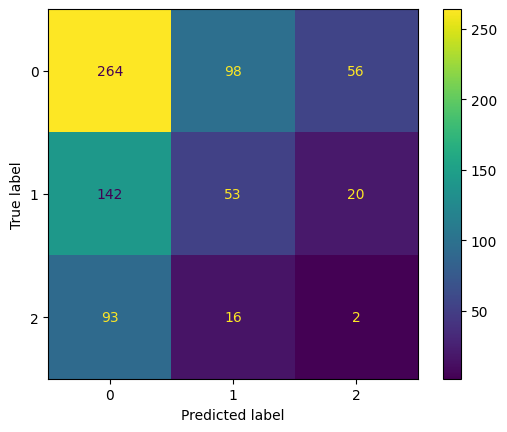

In [ ]:
print(test_classification_report)
disp = ConfusionMatrixDisplay(test_confusion_matrix)
disp.plot()